### Walk through of CoInD using a 2D gaussian example

In [1]:
import sys
import os
parent_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(parent_dir)

import torch
import pytorch_lightning as pl
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from matplotlib import cm
from typing import Optional
import functools
from diffusers import DDPMScheduler
import seaborn as sns

torch.manual_seed(42)
if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'  # Use GPU 1
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')


/research/hal-gaudisac/miniconda3/envs/compositional-generation/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using gpu


### Gaussian Dataset

<Axes: xlabel='None', ylabel='None'>

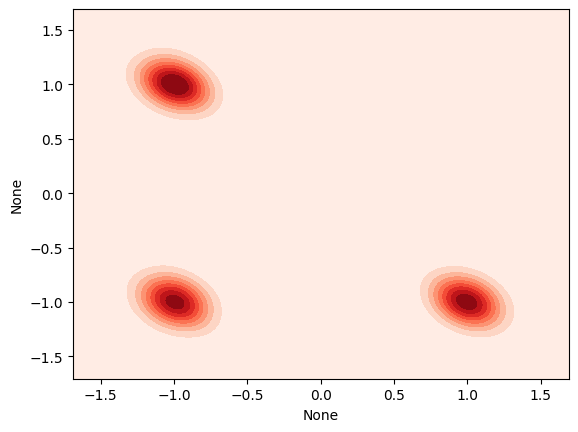

In [2]:
class IndpGaussianDataset(Dataset):
    def __init__(self,data_size:int =200,mode: str = 'train'):
        self.data,self.y = self.inf_train_gen(data_size,mode)
    def inf_train_gen(self,batch_size,mode):
        #normal at (-1,-1), (-1,1), (1,-1), (1,1)
        if mode == 'train':
            xy = torch.tensor([(-1,-1), (-1,1), (1,-1)])
        else:
            xy = torch.tensor([(-1,-1), (-1,1), (1,-1), (1,1)])
        y = torch.randint(len(xy), (batch_size,))
        data = xy[y] + torch.randn(batch_size, 2)*0.1
        y = (xy[y]/2+1.5).to(torch.long)
        return data.float(),y
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):  
        return {
                'X': self.data[idx],
                'label': self.y[idx],
                'label_null': torch.zeros_like(self.y[idx])
            }
#plot dataset
def density_plot(samples):
    return sns.kdeplot(x=samples[:,0], y=samples[:,1], cmap="Reds", fill=True, thresh=0, bw_adjust=0.5)


dataset = IndpGaussianDataset(4096)
#plot dataset
density_plot(dataset.data)

### Train Diffusion model with Conditional Independence

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1,y_dims:list[int]=[], hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.ModuleList([nn.Embedding(y_dims[i], input_dim,dtype=torch.float32) for i in range(len(y_dims))])
        self.y_dim = len(y_dims)*input_dim
        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim+self.y_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim),
            )

    def forward(self, x: Tensor, t: Tensor,y:Optional[Tensor]=None) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()
        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        if y is not None:
            y = torch.cat([self.embedding[i](y[:,i]) for i in range(y.shape[1])], dim=1)
            h = torch.cat([x, t, y], dim=1)
        else:
            h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)


In [4]:
def prepare_labels(y,y_null):
    # prepare labels for diffusion and conditional independence.
    p_null = 0.2
    y_diffusion_obj = torch.where(torch.rand(y.size(0),1,device=y.device) < p_null , y_null, y)
    y_10,y_01,y_11,y_00 = y.clone(),y.clone(),y.clone(), y_null.clone()
    y_10[:,1], y_01[:,0] = y_null[:,1], y_null[:,0]
    y_coind_obj = torch.cat([y_10,y_01,y_11,y_00],dim=0)
    return y_diffusion_obj,y_coind_obj


def train_step(batch,model,noise_scheduler,lambda_coind):
    #diffusion model training with conditional independence
    x0,y,y_null = batch['X'].to(device),batch['label'].to(device),batch['label_null'].to(device)
    y_diffusion_obj,y_coind_obj = prepare_labels(y,y_null)
    noise = torch.randn_like(x0)
    batch_size, num_cols = y.size()
    timesteps = torch.randint(0, noise_scheduler.num_train_timesteps,
                                (batch_size,),device=device).long()
    xt = noise_scheduler.add_noise(x0, noise, timesteps)
    noise_pred = model(xt, timesteps,y_diffusion_obj)
    l_diffusion  = F.mse_loss(noise_pred, noise)
    xt = xt.repeat(4,1,1,1)
    timesteps = timesteps.repeat(4)
    if lambda_coind > 0.0:    
        noise_pred_new = model(xt, timesteps,y_coind_obj).chunk(4,dim=0)
        l_coind = F.mse_loss(noise_pred_new[0]+noise_pred_new[1], noise_pred_new[2]+noise_pred_new[3])
        l = l_diffusion + lambda_coind*l_coind
    return l

In [5]:
import torch
import torch.nn.functional as F
import numpy as np

lr = 3e-4
data_size = 4096
iterations = 5001
hidden_dim = 512
lambda_coind = 1.0
print_every = 1000

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, prediction_type="epsilon", beta_schedule="linear")
epsilon_network = MLP(input_dim=2, time_dim=1,y_dims=[3,3], hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.AdamW(epsilon_network.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)
train_dataloader = DataLoader(dataset, batch_size=data_size, shuffle=True)

for i in range(iterations):
    for batch in train_dataloader:
        loss = train_step(batch,epsilon_network,noise_scheduler,lambda_coind)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    if i % print_every == 0:
        print(f"Step {i}, Loss: {loss.item()}")

/research/hal-gaudisac/miniconda3/envs/compositional-generation/lib/python3.12/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Step 0, Loss: 1.4940813779830933
Step 1000, Loss: 0.2927606403827667
Step 2000, Loss: 0.061665523797273636
Step 3000, Loss: 0.06058447062969208
Step 4000, Loss: 0.0701313391327858
Step 5000, Loss: 0.06540770083665848


#### Sample from trained model

In [18]:
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

class ANDGuidance(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        y_phi = extras['y_null']
        y_10,y_01 = extras['y'].clone(),extras['y'].clone()
        y_10[:,1],y_01[:,0] = y_phi[:,1],y_phi[:,0]
        w1, w2 = 6.0, 6.0
        if 'w' in extras:
            w1, w2 = extras['w']
        result =(self.model(x, t,y_phi))*(1-w1-w2) + w1*self.model(x, t,y_01) + w2*self.model(x, t,y_10)
        return result

class ClassifierFreeGuidance(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        y,y_phi = extras['y'],extras['y_null'] 
        w = 6.0
        if 'w' in extras:
            w = extras['w']
        result =(self.model(x, t,y_phi))*(1-w) + w*self.model(x, t,y)
        return result

epsilon_network.eval()
epsilon_network.to(device)
and_model = ANDGuidance(epsilon_network)
cfg_model = ClassifierFreeGuidance(epsilon_network)

In [21]:
@torch.no_grad()
def sample(model, num_samples,y,y_null,w):
    x = torch.randn(num_samples, 2, device=device)
    extras = {'y':y,'y_null':y_null,'w':w}
    for i in range(1000):
        t = torch.tensor([999 - i], device=device)
        noise_pred = model(x, t, **extras)
        x = noise_scheduler.step(noise_pred, t, x).prev_sample
    return x
w = 5.0
    
y = torch.randint(1,3, (1000,2)).to(device)
y_null = torch.tensor([[0,0]]).repeat(1000,1).to(device)
samples = sample(cfg_model, 1000,y,y_null,w)
density_plot(samples.cpu().detach().numpy())

In [22]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim: int = 2, output_dim: int = 2):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x: Tensor) -> Tensor:
        return self.linear(x)

epochs = 10000
classifier = LinearClassifier().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
classifier.train()
for i in range(epochs):
    optimizer.zero_grad()
    logits = classifier(samples)
    loss = criterion(logits, y[:,0]-1)
    loss.backward()
    optimizer.step()
    scheduler.step()
def plot_classifier(model):
    x = torch.linspace(-1.5, 1.5, 100)
    y = torch.linspace(-1.5, 1.5, 100)
    X, Y = torch.meshgrid(x, y)
    Z = torch.zeros_like(X)
    for i in range(X.size(0)):
        for j in range(X.size(1)):
            z = torch.tensor([X[i,j], Y[i,j]]).to(device)
            with torch.no_grad():
                logits = model(z)
            Z[i,j] = logits.argmax().item()
    plt.contourf(X.numpy(), Y.numpy(), Z.numpy(), alpha=0.5)
    plt.colorbar()
    plt.show()


plot_classifier(classifier)

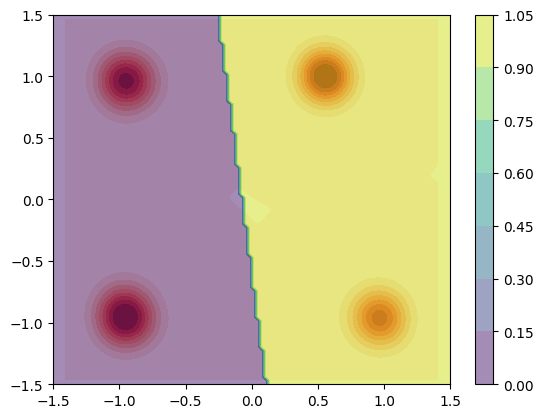